In [ ]:
## Discrete Fourier transform
_CYBR 304 & MATH 420_ <br>
Spring 2024 <br>

The discrete Fourier transform (DFT) multiplies a matrix times a column vector. The matrix is a Vandermonde matrix that has a special structure. For the definition of this
particular Vandermonde matrix, see https://en.wikipedia.org/wiki/Discrete_Fourier_transform.

There are algorithms that take advantage of the special structrue of the matrix to do the matrix multiplication super fast, but for educational purposes, let'first look at a slow, but straightforward way to find the DFT.  After that,  we'll use an award winning Julia package `FFTW` for finding the DFT.

We'll use the Julia function `cis`.  The formula for this function is $\mathrm{cis}(x) = \cos(x) + \mathrm{i} \sin(x)$. The range of the `cis` function is the unit circle.  

Let's start by loading Gadfly and defining a theme for Gadfly plots.


In [1]:
using Gadfly

In [2]:
Gadfly.push_theme(:dark)

First, our pokey slow, but straightforward method

In [3]:
function slow_fft(a)
    n = length(a)
    [cis(-2*pi*i*j/n) for i = 0:n-1, j=0:n-1]*a
end;

And let's try an example

In [4]:
slow_fft([1,2,3,4])

4-element Vector{ComplexF64}:
                10.0 + 0.0im
 -2.0000000000000004 + 1.9999999999999996im
                -2.0 - 9.797174393178824e-16im
 -1.9999999999999982 - 2.000000000000001im

The Julia package `FFTW` (fastest Fourier Transform in the West) is a highly efficient package for computing the DFT. Let's try it

In [5]:
using FFTW

In [7]:
fft([1,2,3,4])

4-element Vector{ComplexF64}:
 10.0 + 0.0im
 -2.0 + 2.0im
 -2.0 + 0.0im
 -2.0 - 2.0im

In [ ]:
Not only is the FFTW method faster, it's also more accurate. The value returned by `fft` is correct to all decimal places, but our poky slow method differs slightly from the true value. Let's abandon our slow and not particularly accurate code.

Let's say that for a real valued function $F$ and a positive integer $N$, we have found the DFT of the finite sequence $F(2 \pi k / N), k \in 0 \dots N-1$ and from that we want to reconstruct the function $F$. We can do that with the function `DFT_to_fn`

In [8]:
function DFT_to_fn(x,a)
    n = length(a)
    k = 0
    s = zero(x)
    for c in a 
        s += (if k==0 1 elseif k < n-2 2 else 0 end)*real(c*cis(k*x))
        k += 1
    end
    s
end;

Let's try this out. 

In [9]:
function F(x) 
    -8*sin(x) + 10*cos(2*x)
end;

In [10]:
N = 256;

In [11]:
a = fft([F(2*pi*k/N) for k=0:N-1])/N;

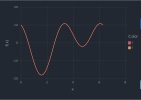

In [13]:
plot([F, x -> DFT_to_fn(x,a)],0,2*pi)

In [ ]:
Here is a graph of the difference between the function $F$ and the function we reconstructed from the DFT. It's a crazy looking graph, but the differences have a magnitude that are of the order $10^{-14}$. So for this case, our code seems to work OK.

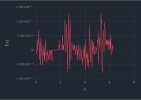

In [15]:
plot(x -> F(x) - DFT_to_fn(x,a),0,2*pi)

Let's have some fun. To the function $x \mapsto  -8 \sin(x) + 10 \cos(2 x)$, let's add some randomness. If we were in a music studio recording, the function
 $x \mapsto  -8 \sin(x) + 10 \cos(2 x)$ represents to a sound with different amplitudes and two frequencies one octave apart. And the randomness would represent a higher
 frequency noise. To get consistent results from our function $F$, we'll set the seed for the random number generator. Here is our function

In [16]:
using Random
seed_value = 0
Random.seed!(seed_value);

In [17]:
function F(x) 
      -8*sin(x) + 10*cos(2*x) + 10*(rand()-0.5)/4
end

F (generic function with 1 method)

In [18]:
a = fft([F(2*pi*k/N) for k=0:N-1])/N;

Both the function $F$ and the function we reconstruct from the DFT have crazy wiggles in them from the noise

In [19]:
Random.seed!(seed_value);

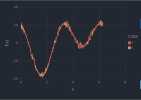

In [21]:
plot([F, x -> DFT_to_fn(x,a)],0,2*pi)

In [ ]:
We can get rid of the high frequency noise by reducing the magnitude of the value of the DFT for the higher frequency terms.  We'll do this by appending a function to our function that multplies the the discrete Fourier coeficients

In [22]:
function DFT_to_fn(x,a,fn)
    n = length(a)
    k = 0
    s = 0
    for c in a 
        s += (if k==0 1 elseif k < n-2 2 else 0 end)*real(fn(k)*c*cis(k*x))
        k += 1
    end
    s
end

DFT_to_fn (generic function with 2 methods)

In [ ]:
Here is a simple 'filter' that sets all the coeficients that are larger than 10 to zero.

In [23]:
function filter(k)
    if k < 10 1 else 0 end
end

filter (generic function with 1 method)

In [24]:
Random.seed!(seed_value);

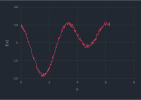

In [26]:
plot([F],0,2*pi)

In [269]:
Random.seed!(seed_value);

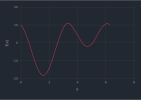

In [28]:
plot([x -> DFT_to_fn(x,a,filter)],0,2*pi)

In [ ]:
If we retain all frequencies less than 30, our reconstructed function is a bit more "wiggly."

In [29]:
function filter(k)
    if k < 30 1 else 0 end
end

filter (generic function with 1 method)

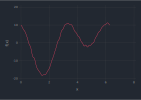

In [31]:
plot([x -> DFT_to_fn(x,a,filter)],0,2*pi)